In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import gym
from torchsummary import summary
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import numpy as np
from batchup import data_source
from IPython.display import clear_output

In [2]:
def plot(losses):
    clear_output(True)
    plt.plot(losses)
    plt.show()
    

In [3]:
env = gym.make('Pendulum-v0')

In [4]:
class Encode(nn.Module):
    def __init__(self):
        super().__init__()
        self.encode = nn.Sequential(nn.Conv2d(1,16,kernel_size=3, padding=1),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2,2),
                                   nn.Conv2d(16,256,kernel_size=3, padding=1),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2,2),
                                   nn.Conv2d(256,16,kernel_size=3, padding=1),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2,2), 
                                   )
        self.decode = nn.Sequential(nn.ConvTranspose2d(16,256,2, stride=2),
                                   nn.ReLU(),
                                   nn.ConvTranspose2d(256,16,2, stride=2),
                                   nn.ReLU(),
                                   nn.ConvTranspose2d(16,1,2, stride=2),
                                   nn.Sigmoid())
    def forward(self, state):
        return self.decode(self.encode(state))
    
    def encd(self,state):
        return self.encode(state)

In [5]:
model = Encode()

In [6]:
model = model.cuda()

In [7]:
summary(model, (1,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             160
              ReLU-2         [-1, 16, 128, 128]               0
         MaxPool2d-3           [-1, 16, 64, 64]               0
            Conv2d-4          [-1, 256, 64, 64]          37,120
              ReLU-5          [-1, 256, 64, 64]               0
         MaxPool2d-6          [-1, 256, 32, 32]               0
            Conv2d-7           [-1, 16, 32, 32]          36,880
              ReLU-8           [-1, 16, 32, 32]               0
         MaxPool2d-9           [-1, 16, 16, 16]               0
  ConvTranspose2d-10          [-1, 256, 32, 32]          16,640
             ReLU-11          [-1, 256, 32, 32]               0
  ConvTranspose2d-12           [-1, 16, 64, 64]          16,400
             ReLU-13           [-1, 16, 64, 64]               0
  ConvTranspose2d-14          [-1, 1, 1

In [8]:
data = np.zeros((5000,1,128,128))
state = env.reset()
done  = False
for i in range(5000):
    if done:
        state = env.reset()
    image = env.render(mode="rgb_array")
    image = cv2.resize(image, (128,128))
    image = cv2.cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).reshape(1,128,128)
    data[i] = image/255
    state, re, done, _ = env.step(env.action_space.sample())
    
env.close()

In [9]:
opti = torch.optim.Adam(model.parameters())
crit = nn.MSELoss()

In [10]:
ds = data_source.ArrayDataSource([data])

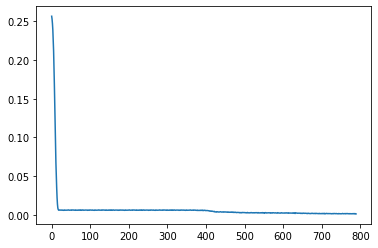

In [11]:
lol = []
for i in range(10):
    for (batch_X) in ds.batch_iterator(batch_size=64, shuffle=np.random.RandomState(12345)):
        images = batch_X[0]
        images = torch.FloatTensor(images).cuda()
        
        enc = model(images)
        loss = crit(enc, images)
        opti.zero_grad()
        loss.backward()
        opti.step()
        lol.append(loss.item())
    plot(lol)
        

In [22]:
a = enc[5].cpu().detach()

In [23]:
s = a.numpy()

In [33]:
s = s*255
s = s.astype(np.uint8)

In [34]:
s = s.reshape(128,128)

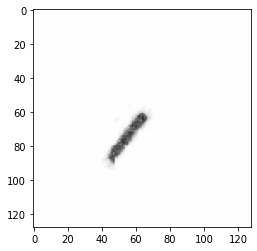

In [35]:
plt.imshow(s, cmap='gray', vmin=0, vmax=255)

In [18]:
torch.save(model.state_dict(), "encode.pt")